In [1]:
# for google colab runs
# %cd /content/drive/MyDrive/colab\ files
# !pwd

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))

def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

2023-04-16 16:34:53.339153: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-16 16:34:53.924497: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


python 3.9.16 (main, Mar  8 2023, 14:00:05) 
[GCC 11.2.0]
keras version 2.12.0
tensorflow version 2.12.0


In [2]:
# !pip install opendatasets
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/datasets/adityajn105/flickr8k")

Skipping, found downloaded files in "./flickr8k" (use force=True to force download)


In [3]:
## The location of the Flickr8K_ photos
dir_Flickr_jpg = "./flickr8k/Images"
# dir_Flickr_jpg = "/content/drive/MyDrive/colab files/flickr8k/Images"

## The location of the caption file
dir_Flickr_text = "./flickr8k/captions.txt"
# dir_Flickr_text = "/content/drive/MyDrive/colab files/flickr8k/captions.txt"

jpgs = os.listdir(dir_Flickr_jpg)
print("The number of jpg flies in Flicker8k: {}".format(len(jpgs)))

The number of jpg flies in Flicker8k: 8092


## Preliminary Analysis

In [4]:
df_txt = pd.read_csv(dir_Flickr_text, skiprows=1, names=["filename", "caption"])
df_txt['caption'] = df_txt['caption'].str.lower()

df_txt['index'] = df_txt.groupby("filename").cumcount()

uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:")
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 8091
The distribution of the number of captions for each image:


Counter({5: 8091})

In [5]:
import string

# Remove punctuations..
def remove_punctuation(text_original):
    text_no_punctuation = text_original.translate(str.maketrans('', '', string.punctuation))
    return(text_no_punctuation)

# Remove a single character word..
def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

# Remove words with numeric values..
def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)

In [6]:
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [7]:
def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":ct.keys(),"count":ct.values()})
    dfword = dfword.sort_values(by="count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 8763


,word,count
0,in,18974
1,the,18418
2,on,10743


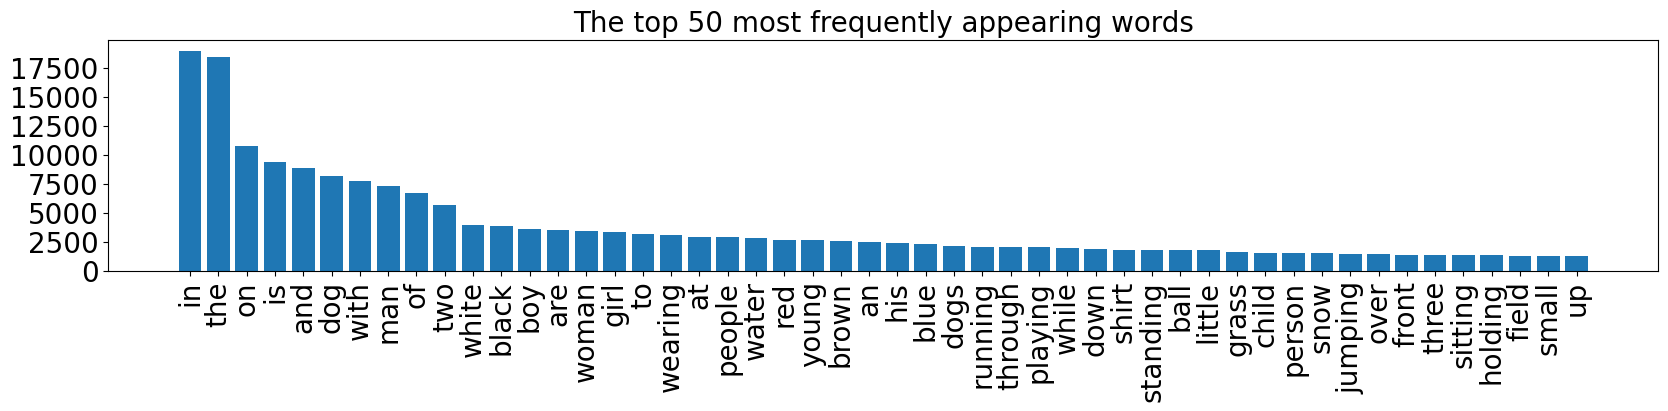

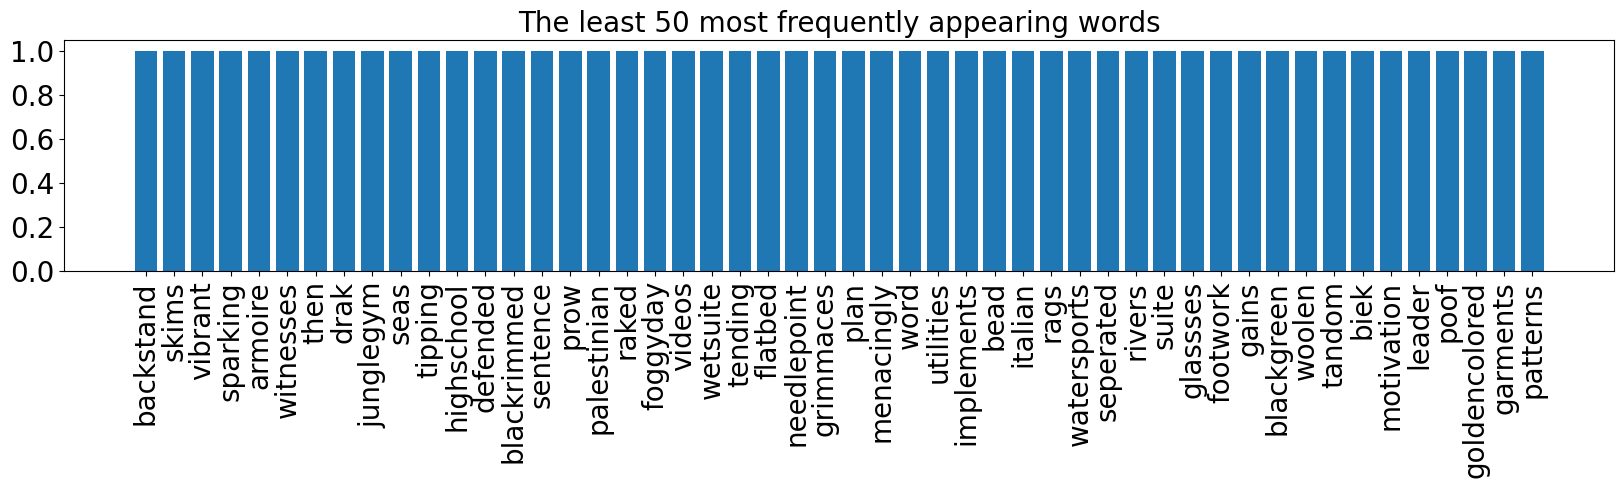

In [8]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")
plthist(dfword.iloc[-topn:,:],
        title="The least 50 most frequently appearing words")

# Data prepration
prepare text and image separately

In [9]:
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)

df_txt["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt.head(5)

,filename,caption,index
0,1000268201_693b08cb0e.jpg,startseq child in pink dress is climbing up s...,0
1,1000268201_693b08cb0e.jpg,startseq girl going into wooden building endseq,1
2,1000268201_693b08cb0e.jpg,startseq little girl climbing into wooden pla...,2
3,1000268201_693b08cb0e.jpg,startseq little girl climbing the stairs to h...,3
4,1000268201_693b08cb0e.jpg,startseq little girl in pink dress going into...,4


# split the dataset int train and test splits

In [10]:
from sklearn.model_selection import train_test_split

# create a list of unique image file names in your DataFrame (df_txt) using the unique method of pandas:
unique_files = df_txt['filename'].unique()

# Split the list of unique file names into train and test sets using the train_test_split function from scikit-learn:
train_files, test_files = train_test_split(unique_files, test_size=0.2, random_state=42)

# Filter the original DataFrame to include only the rows corresponding to the image files in the train and test sets:
train_df = df_txt[df_txt['filename'].isin(train_files)]
test_df = df_txt[df_txt['filename'].isin(test_files)]

# Verify that there is no leakage by checking if there are any image file names that appear in both the train and test sets:
assert len(set(train_df['filename']).intersection(set(test_df['filename']))) == 0

# Image prepration
## create features for image using InceptionV3 model

In [11]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model

base_model = InceptionV3(weights='imagenet')
image_model = Model(inputs = base_model.input, outputs=base_model.layers[-2].output)

In [12]:
from tensorflow.keras.utils import load_img, img_to_array
from keras.applications.inception_v3 import preprocess_input
import glob
import pickle

train_path = dir_Flickr_jpg
path_all_images = glob.glob(train_path + '/*jpg')

train_img = []  # list of all images in training set
test_img = []
for im in path_all_images:
    file_name = os.path.basename(os.path.normpath(im))
    # include images that only exist in the target directory
    # can split the dataset this way
    if(file_name in train_df.filename.to_list()):
        train_img.append(im)
    elif (file_name in test_df.filename.to_list()):
        test_img.append(im)
    else:
        print(f"{file_name} not in the directory")
    

def preprocess(image_path):
    # inception v3 excepts img in 299 * 299 * 3
    image = load_img(image_path, target_size=(299, 299))
    # convert the image pixels to a numpy array
    x = img_to_array(image)
    # Add one more dimension
    x = np.expand_dims(x, axis = 0)
    x = preprocess_input(x)
    return x

def encode(image_path):
    image = preprocess(image_path)
    vec = image_model.predict(image, verbose=0)
    vec_flattened = vec.flatten()
    return vec_flattened


train_img_feats = {}
test_img_feats = {}

if not (os.path.exists('train_encoder.pkl') and os.path.exists('test_encoder.pkl')):
    for image in train_img:
        file_name = os.path.basename(os.path.normpath(image))
        train_img_feats[file_name] = encode(image)
    for image in test_img:
        file_name = os.path.basename(os.path.normpath(image))
        test_img_feats[file_name] = encode(image)
    # Save the image features
    with open('train_encoder.pkl', 'wb') as f:
        pickle.dump(train_img_feats, f)
    with open('test_encoder.pkl', 'wb') as f:
        pickle.dump(test_img_feats, f)
else:
    # Load previously encoded image data
    with open('train_encoder.pkl', 'rb') as f:
        train_img_feats = pickle.load(f)
    with open('test_encoder.pkl', 'rb') as f:
        test_img_feats = pickle.load(f)

# Tokenize the captions

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

vocab_size = 8000
# Tokenizer does not limit the number of words
# it still finds all the words in the word_index
# But it will only use the num_words given to encode the text in texts_to_sequences or sequences_to_texts methods
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(train_df.caption.to_list())

# get the word index
train_seqs = tokenizer.texts_to_sequences(train_df.caption.to_list())
test_seqs = tokenizer.texts_to_sequences(test_df.caption.to_list())

# calculate the maximum caption length
max_length = max(len(seq) for seq in train_seqs)

In [14]:
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(df, tokenizer, max_length, image_data, batch_size, generator_type):
    num_batches = len(df) // batch_size
    while True:
        df = df.sample(frac=1).reset_index(drop=True) # shuffle the data
        for i in range(num_batches):
            batch_df = df.iloc[i*batch_size:(i+1)*batch_size]
            X1, X2, y = [], [], []
            for index, row in batch_df.iterrows():
                try:
                    # try to get the image features from the image_data dictionary
                    pic = image_data[row['filename']]
                except KeyError:
                    # if the file name is not found, print a warning message and skip this row
                    print(f"""Warning ({generator_type} generator):
                          file name {row['filename']} not found in image_data dictionary. Skipping this row.""")
                    continue
                seq = tokenizer.texts_to_sequences([row['caption']])[0]
                for j in range(1, len(seq)):
                    in_seq, out_seq = seq[:j], seq[j]
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=len(tokenizer.word_index)+1)[0]
                    # out_seq = [out_seq]
                    X1.append(pic)
                    X2.append(in_seq)
                    y.append(out_seq)
            yield ([np.array(X1), np.array(X2)], np.array(y))

batch_size = 64
# create data generator for the train set
train_generator = data_generator(train_df, tokenizer, max_length, train_img_feats, batch_size, generator_type="train")

# create data generator for the test set
test_generator = data_generator(test_df, tokenizer, max_length, test_img_feats, batch_size, generator_type="val")

# Downloading GloVe to using its vector embeddings

In [15]:
import urllib.request
import zipfile

# Set the URL for the GloVe embeddings
url = 'http://nlp.stanford.edu/data/glove.6B.zip'

# Set the path where the embeddings will be stored
embeddings_dir = 'embeddings/glove'

# Create the directory if it doesn't exist
if not os.path.exists(embeddings_dir):
    os.makedirs(embeddings_dir)

# Set the file name for the embeddings archive
embeddings_zip = os.path.join(embeddings_dir, 'glove.6B.zip')

# Download the embeddings archive if it doesn't exist
if not os.path.exists(embeddings_zip):
    print(f'Downloading GloVe embeddings from {url}...')
    urllib.request.urlretrieve(url, embeddings_zip)
    print('Done!')

# Extract the embeddings if they haven't been extracted yet
if not os.path.exists(os.path.join(embeddings_dir, 'glove.6B.100d.txt')):
    print('Extracting GloVe embeddings...')
    with zipfile.ZipFile(embeddings_zip, 'r') as zip_ref:
        zip_ref.extractall(embeddings_dir)
    print('Done!')


In [ ]:
# load GloVe embeddings
embeddings_index = {}
glove_path = "./embeddings/glove/glove.6B.200d.txt"

with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# filter out the words that are not in the top num_words-1 most frequent words
# filtered_word_index = {word: i for word, i in tokenizer.word_index.items() if i < vocab_size}
assert len(tokenizer.word_index) >= vocab_size, f"""the specified vocab size is larger than the tokenizer word_index.\n
        vocab_size={vocab_size}, length of tokenizer.word_index={len(tokenizer.word_index)}"""
# prepare embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

# Define the model

In [17]:
image_input_values = list(train_img_feats.values())
n_img_features = np.array(image_input_values).shape[1]

In [36]:
from tensorflow.keras import layers, Model

# define the model
image_input = layers.Input(shape = (n_img_features, ))
fe1 = layers.Dropout(0.2)(image_input)
fe2 = layers.Dense(256, activation = 'relu')(fe1)

caption_input = layers.Input(shape = (max_length, ))
embedding_layer = layers.Embedding(vocab_size, embedding_dim,
                                   weights = [embedding_matrix],
                                   input_length = max_length,
                                   mask_zero = True,
                                   trainable = False)(caption_input)
se2 = layers.Dropout(0.2)(embedding_layer)
se3 = layers.LSTM(256)(se2)
decoder1 = layers.add([fe2, se3])
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
outputs = layers.Dense(vocab_size)(decoder2)
model = Model(inputs = [image_input, caption_input], outputs = outputs)
print(model.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 34, 200)      1600000     ['input_5[0][0]']                
                                                                                                  
 dropout_2 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

In [63]:
from tensorflow.keras.layers import Dropout, Dense, Embedding, LSTM, Input, add

# Merge model
def define_merge_model(n_img_features, vocab_size, max_length, embedding_dim, embedding_matrix):
    # feature extractor model
    image_input = layers.Input(shape = (n_img_features, ))
    fe1 = Dropout(0.5)(image_input)
    fe2 = Dense(256, activation='relu')(fe1)
    # sequence model
    caption_input = layers.Input(shape = (max_length, ))
    embedding_layer = layers.Embedding(vocab_size, embedding_dim,
                                   weights = [embedding_matrix],
                                   input_length = max_length,
                                   mask_zero = True,
                                   trainable = False)(caption_input)
    se2 = Dropout(0.5)(embedding_layer)
    se3 = LSTM(256)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[image_input, caption_input], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    # plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [138]:
# # RNN Decoder
# decoder = Sequential([
#     layers.Input(shape=(None,)),
#     layers.Embedding(vocab_size, embedding_dim, mask_zero=True),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.LSTM(256, return_sequences=True),
#     layers.Dropout(0.5),
#     layers.TimeDistributed(layers.Dense(256, activation='relu')),
#     layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))
# ])

# # Combine Encoder and Decoder
# image_input  = layers.Input(shape = (image_input.shape[1], ))
# fe1 = layers.Dropout(0.2)(image_input )
# features  = layers.Dense(256, activation = 'relu')(fe1)
# caption_input = layers.Input(shape=(max_length,))

# # features = layers.Dropout(0.5)(features)
# sequence = decoder(caption_input)
# sequence = layers.Dropout(0.5)(sequence)
# context = layers.Attention()([features, sequence])
# outputs = layers.concatenate([context, sequence])
# outputs = layers.TimeDistributed(layers.Dense(256, activation='relu'))(outputs)
# outputs = layers.TimeDistributed(layers.Dense(vocab_size, activation='softmax'))(outputs)

# model3 = Model(inputs=[image_input, caption_input], outputs=outputs)

In [ ]:
input_image = layers.Input(shape = (image_input.shape[1], ))
fimage = layers.Dense(256, activation='relu', name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(max_length,))
ftxt = layers.Embedding(vocab_size, embedding_dim, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256, name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([fimage, ftxt])
decoder = layers.Dense(256, activation='relu')(decoder)
output = layers.Dense(vocab_size, activation='softmax')(decoder)
model_v2 = Model(inputs=[input_image, input_txt], outputs=output)

model_v2.compile(loss='categorical_crossentropy', optimizer='adam')
print(model_v2.summary())

# Train the model

In [71]:
model_merge = define_merge_model(n_img_features, vocab_size, max_length, embedding_dim, embedding_matrix)

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 34)]         0           []                               
                                                                                                  
 input_20 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_8 (Embedding)        (None, 34, 200)      1600000     ['input_21[0][0]']               
                                                                                                  
 dropout_17 (Dropout)           (None, 2048)         0           ['input_20[0][0]']               
                                                                                            

In [72]:
from tensorflow.keras.callbacks import ModelCheckpoint
# define checkpoint callback
filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

num_batches = len(train_df) // batch_size
num_val_batches = len(test_df) // batch_size

hist = model_merge.fit(train_generator,
          validation_data=test_generator,
          validation_steps=num_val_batches,
          epochs = 5,
          steps_per_epoch=num_batches,
          verbose = 1)

Epoch 1/5


2023-04-16 16:34:11.792978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-04-16 16:34:14.169043: I tensorflow/core/common_runtime/executor.cc:1197] [/job:localhost/replica:0/task:0/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: logits and labels must be broadcastable: logits_size=[669,8000] labels_size=[669,7974]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]]


InvalidArgumentError: Graph execution error:

Detected at node 'categorical_crossentropy/softmax_cross_entropy_with_logits' defined at (most recent call last):
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_387969/4122301143.py", line 9, in <module>
      hist = model_merge.fit(train_generator,
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1685, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1284, in train_function
      return step_function(self, iterator)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1268, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1249, in run_step
      outputs = model.train_step(data)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_step
      loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/training.py", line 1109, in compute_loss
      return self.compiled_loss(
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 265, in __call__
      loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 142, in __call__
      losses = call_fn(y_true, y_pred)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 268, in call
      return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/losses.py", line 1984, in categorical_crossentropy
      return backend.categorical_crossentropy(
    File "/home/mirshahi/miniconda3/envs/tf/lib/python3.9/site-packages/keras/backend.py", line 5565, in categorical_crossentropy
      return tf.nn.softmax_cross_entropy_with_logits(
Node: 'categorical_crossentropy/softmax_cross_entropy_with_logits'
logits and labels must be broadcastable: logits_size=[669,8000] labels_size=[669,7974]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_46312]

In [92]:


# define loss function
def sparse_loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = tf.keras.losses.sparse_categorical_crossentropy(real, pred, from_logits=True) # add from_logits argument
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

model.compile(loss = sparse_loss_function, optimizer = 'adam',
               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

num_batches = len(train_df) // batch_size
num_val_batches = len(test_df) // batch_size



In [ ]:
hist = model.fit(train_generator,
          validation_data=test_generator,
          validation_steps=num_val_batches,
          epochs = 5,
          steps_per_epoch=num_batches,
          verbose = 1)

In [ ]:
model3.compile(loss = sparse_loss_function, optimizer = 'adam',
               metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
hist = model3.fit(train_generator,
          validation_data=test_generator,
          validation_steps=num_val_batches,
          epochs = 5,
          steps_per_epoch=num_batches,
          verbose = 1)

## Saving the model

In [31]:
with open('model_histpry.pkl', 'wb') as f:
    pickle.dump(hist, f)

In [25]:
with open('model_histpry.pkl', 'rb') as f:
    hist = pickle.load(f)

EOFError: Ran out of input

In [20]:
# define some custom metadata for the model
metadata = {
  'name': 'image_caption_generator',
  'description': 'A model that generates captions for images using InceptionV3 and have all the stop words, and with no lemmatization',
  'parameters': {
    'vocab_size': 8000,
    'embedding_dim': 200,
    'lstm_units': 256,
    'beam_size': 5
  },
  'performance': {
    'loss': 1.6700,
    'accuracy': 'Nan',
    'bleu_score': 'NaN'
  }
}

# save the model with the metadata
model.save('capGen_model_v1.5.h5')

In [20]:
model = tf.keras.models.load_model('capGen_model_v1.5.h5', custom_objects={'sparse_loss_function': sparse_loss_function})

In [68]:
model_old = tf.keras.models.load_model('caption_generator_inceptionV3.h5')

# BLEU Score

In [26]:
def predict_caption_eval(image_vec):
    image_vec = image_vec.reshape(1, -1)
    # initialize the caption with the start token
    caption = [tokenizer.word_index['startseq']]
    # loop until the end token or the maximum length is reached

    for i in range(max_length):
        padded_caption = pad_sequences([caption], maxlen=max_length, padding='post')
        # predict the next word using the model
        prediction = model.predict([image_vec, padded_caption], verbose=0)
        # get the word with the highest probability
        word_index = np.argmax(prediction)
        # append the word to the caption
        caption.append(word_index)
        # break if the end token is reached
        if word_index == tokenizer.word_index['endseq']:
            break
    # convert the caption indices to words
    caption_words = [tokenizer.index_word[i] for i in caption]
    # join the words to form a sentence
    caption_sentence = ' '.join(caption_words[1:-1])
    return caption_sentence

In [27]:
from nltk.translate.bleu_score import sentence_bleu

index_word = tokenizer.index_word

nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
# fname: filenames from the dataframe
# dt_test: tokenized text from tokenizer.texts_to_sequences()
# di_test: image feature arrays
test_img_feats_array = np.array(list(test_img_feats.values()))
for jpgfnm, image_feature, tokenized_text in zip(test_df.filename.to_list(), test_img_feats_array, test_seqs):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(test_df)/5)))

    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startseq, and endseq
    ## captions
    caption = predict_caption_eval(image_feature)
    caption = caption.split()

    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.7 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

/home/mirshahi/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/mirshahi/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/mirshahi/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use Smoothi

  0.49% is done..
  0.99% is done..
  1.48% is done..
  1.98% is done..
  2.47% is done..
  2.96% is done..
  3.46% is done..
  3.95% is done..


In [28]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.001


# Predicting a caption for new image
## greedy search and beam serach

In [57]:
test_df.caption.iloc[0]

'startseq  couple and an infant being held by the male sitting next to pond with near by stroller endseq'

filename: ./flickr8k/Images/1022454428_b6b660a67b.jpg
caption ['couple', 'and', 'an', 'infant', 'being', 'held', 'by', 'the', 'male', 'sitting', 'next', 'to', 'pond', 'with', 'near', 'by', 'stroller']


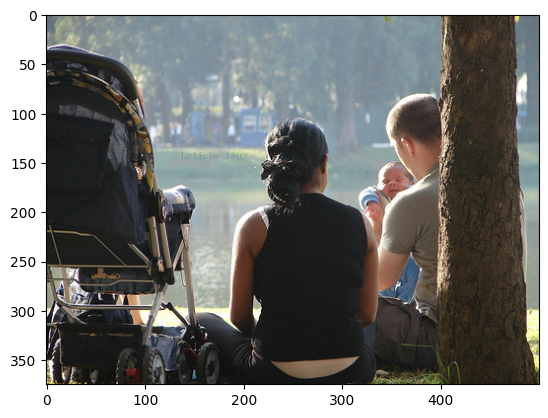

In [62]:
test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]
true_caption = test_df.caption.iloc[0]
true_caption = [ index_word[i] for i in tokenizer.texts_to_sequences([true_caption])[0] ] 
print(f"filename: {test_file_dir}\ncaption {true_caption[1:-1]}")
test_img_feats[test_df.filename.iloc[0]]

from PIL import Image

# Load an image
img = Image.open(test_file_dir)
plt.imshow(img)


In [71]:
def predict_greedy_search(image_path, model):
    # encode the image
    image_vec = encode(image_path)
    # reshape the vector, because our batch only includes 1 file prediction
    image_vec = image_vec.reshape(1, -1)
    # initialize the caption with the start token
    caption = [tokenizer.word_index['startseq']]
    # loop until the end token or the maximum length is reached

    for i in range(max_length):
        padded_caption = pad_sequences([caption], maxlen=22, padding='post')
        # predict the next word using the model
        prediction = model.predict([image_vec, padded_caption], verbose=0)
        # get the word with the highest probability
        word_index = np.argmax(prediction)
        # append the word to the caption
        caption.append(word_index)
        # break if the end token is reached
        if word_index == tokenizer.word_index['endseq']:
            break
    # convert the caption indices to words
    caption_words = [tokenizer.index_word[i] for i in caption]
    # join the words to form a sentence
    caption_sentence = ' '.join(caption_words[1:-1])
    return caption_sentence

test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]
generated_caption = predict_greedy_search(test_file_dir, model_old)
print(generated_caption)

the dog newspapers woodland out their


In [72]:
def predict_beam_search(image_path, beam_width, tokenizer, model):
    # encode the image
    image_vec = encode(image_path)
    image_vec = image_vec.reshape(1, -1)
    # initialize the caption with the start token
    caption = tokenizer.texts_to_sequences(["startseq"])[0]
    # initialize beam search
    beam = [(caption, 0)]
    
    # loop until the end token or the maximum length is reached
    for i in range(max_length):
        # generate new candidates
        candidates = []
        for j in range(len(beam)):
            seq, score = beam[j]
            # check if the sequence ends with endseq
            if seq[-1] == tokenizer.word_index["endseq"]:
                candidates.append((seq, score))
                continue
            # predict the next word using the model
            padded_caption = pad_sequences([seq], maxlen=max_length, padding='post')
            prediction = model.predict([image_vec, padded_caption], verbose=0)[0]
            # get the top k words with the highest probability
            top_k = prediction.argsort()[-beam_width:][::-1]
            # add new candidates to the list
            for w in top_k:
                new_seq = seq + [w]
                new_score = score + np.log(prediction[w])
                candidates.append((new_seq, new_score))
        # select top k candidates
        beam = sorted(candidates, key=lambda x: x[1], reverse=True)[:beam_width]
        
    # select the best candidate
    seq, score = beam[0]
    # convert the caption indices to words
    caption_words = tokenizer.sequences_to_texts([seq])[0].split()
    # join the words to form a sentence
    caption_sentence = ' '.join(caption_words[1:-1])
    return caption_sentence

In [73]:
test_file_dir = dir_Flickr_jpg + '/' + test_df.filename.iloc[0]

generated_caption = predict_beam_search(test_file_dir, 10, tokenizer, model=model_old)
print(generated_caption)

on dog brown small


# Model 2, more complicated
* You can use a bidirectional LSTM instead of a single LSTM for the caption encoder. This way, you can capture the context from both directions of the caption sequence, and generate more coherent captions.

* You can use an attention mechanism to allow the decoder to focus on different parts of the image and the caption encoder outputs at each time step. This way, you can generate more relevant and informative captions that align with the image content.

* You can use a scheduled sampling technique to train the decoder with a mix of ground truth and predicted words. This way, you can reduce the exposure bias and improve the generalization ability of the decoder.

* You can use a beam search instead of a greedy search for generating captions. This way, you can explore more possible captions and choose the one with the highest probability.

In [ ]:
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Attention

# define the model
ip1 = layers.Input(shape = (2048, ))
fe1 = layers.Dropout(0.2)(ip1)
fe2 = layers.Dense(256, activation = 'relu')(fe1)
ip2 = layers.Input(shape = (max_length, ))
se1 = layers.Embedding(vocab_size, embedding_dim, mask_zero = True)(ip2)
se2 = layers.Dropout(0.2)(se1)
se3 = Bidirectional(layers.LSTM(256, return_sequences=True))(se2) # use bidirectional LSTM
decoder1 = layers.add([fe2, se3[:, -1]]) # use last hidden state of bidirectional LSTM
decoder2 = layers.Dense(256, activation = 'relu')(decoder1)
attn_layer = Attention() # use attention layer
context_vector, attention_weights = attn_layer([decoder2, se3]) # get context vector and attention weights
decoder3 = layers.Dense(256, activation='relu')(context_vector) # use context vector for final dense layer
outputs = layers.Dense(vocab_size, activation = 'softmax')(decoder3)
model_v2 = Model(inputs = [ip1, ip2], outputs = outputs)

model_v2.layers[3].set_weights([embedding_matrix])
model_v2.layers[3].trainable = False
model_v2.compile(loss = 'categorical_crossentropy', optimizer = 'adam')

num_batches = len(df_txt0) // batch_size
model_v2.fit(train_generator, epochs = 50, steps_per_epoch=num_batches, verbose = 1)

## Beam search

In [ ]:
def beam_search(image_path, beam_size):
  # encode the image
  image_vec = encode(image_path)
  # add another dimension to match the model input
  image_vec = np.expand_dims(image_vec, axis=0)
  # initialize the candidates with the start token
  candidates = [[tokenizer.word_index['<start>']]]
  # initialize the probabilities with 1
  probabilities = [1]
  # loop until the maximum length is reached
  for i in range(max_length):
    # initialize a list to store the next candidates
    next_candidates = []
    # initialize a list to store the next probabilities
    next_probabilities = []
    # loop over the current candidates
    for j in range(len(candidates)):
      # get the current candidate
      candidate = candidates[j]
      # pad the candidate sequence
      padded_candidate = pad_sequences([candidate], maxlen=max_length, padding='post')
      # predict the next word using the model
      prediction = model.predict([image_vec, padded_candidate], verbose=0)
      # get the top beam_size words and their probabilities
      top_words = np.argsort(prediction[0])[-beam_size:]
      top_probs = prediction[0][top_words]
      # loop over the top words and their probabilities
      for k in range(beam_size):
        # get the word and its probability
        word = top_words[k]
        prob = top_probs[k]
        # append the word to the candidate and multiply the probability
        next_candidate = candidate + [word]
        next_prob = probabilities[j] * prob
        # append the next candidate and probability to the lists
        next_candidates.append(next_candidate)
        next_probabilities.append(next_prob)
    # sort the next candidates and probabilities by descending order of probability
    sorted_indices = np.argsort(next_probabilities)[::-1]
    sorted_candidates = [next_candidates[i] for i in sorted_indices]
    sorted_probabilities = [next_probabilities[i] for i in sorted_indices]
    # select the top beam_size candidates and probabilities for the next iteration
    candidates = sorted_candidates[:beam_size]
    probabilities = sorted_probabilities[:beam_size]
    # check if any candidate has reached the end token
    end_index = tokenizer.word_index['<end>']
    if any(candidate[-1] == end_index for candidate in candidates):
      break
  # return the candidate with the highest probability
  best_candidate = candidates[0]
  # convert the candidate indices to words
  caption_words = [tokenizer.index_word[i] for i in best_candidate]
  # join the words to form a sentence
  caption_sentence = ' '.join(caption_words[1:-1])
  return caption_sentence

In [ ]:
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.utils import to_categorical
import tensorflow as tf

def data_generator(df, image_data, batch_size):
    # create a dataset from the data frame
    ds = tf.data.Dataset.from_tensor_slices((df['filename'], df['caption']))
    # map the filename to the image data
    ds = ds.map(lambda x, y: (image_data[x], y))
    # apply the TextVectorization layer as a transformation
    ds = ds.map(lambda x, y: (x, vectorizer([y])))
    # unbatch the dataset to get individual elements
    ds = ds.unbatch()
    # create input and output sequences
    ds = ds.map(lambda x, y: (x, y[:-1], y[1:]))
    # pad and one-hot encode the sequences if needed
    # ds = ds.map(lambda x, y, z: (x, pad_sequences([y], maxlen=max_length)[0], to_categorical([z], num_classes=vocab_size)[0]))
    # batch the dataset
    ds = ds.batch(batch_size)
    return ds

batch_size = 64
train_generator = data_generator(df_txt, image_data, batch_size)